In [1]:
import numpy as np
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

In [2]:
# metric:
# the result (experiments) should be done for each alpha
# patch-level
# - empirical coverage (misconverage rate could be obtained from 1 - empirical coverage)
#   - total
#   - only for ihc_score 0,1,2-,2+,3+
#   - only for label 0, 1
# - average set size
#   - total
#   - only for ihc_score 0,1,2-,2+,3+
#   - only for label 0, 1
# - accuracy/precision/recall/f1 for confident predictions only
# - ambiguity rate (size = 2)
#   - total
#   - only for ihc_score 0,1,2-,2+,3+
#   - only for label 0, 1

# case-level
# precision/recall/f1
# ambiguity rate (for case)


In [3]:
root = "/home/surayuth/her2/results_cp/orig_feat_level_16_white_balance_False_scale_0.25_trial_50_n_est_100_model_rf_dryrun_ True"
root = Path(root)
cv = 3
r_min = 0
r_max = 100
alphas = [0.01, 0.05, 0.1, 0.15, 0.2]

Text(0.5, 1.0, 'Patch level')

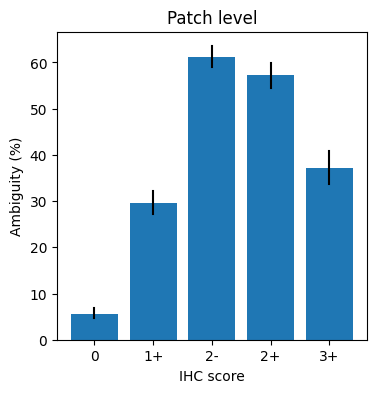

In [4]:
# What is the relation Ambi and label for each alpha
# graph: relation between Ambi and IHC score

def average_set_size(df):
    sizes = []
    for j in range(5):
        fdf = df \
            .filter(
                pl.col("ihc_score") == j
            )
        size = fdf.select("pred_size").mean().item()
        sizes.append(size)
    return sizes

rows = []
for r in range(r_min, r_max + 1):
    for f in range(cv):
        for alpha in alphas:
            file_path = root / f"{r}_{f}" / f"{r}_{f}_{alpha}_result.csv"

            df = pl.read_csv(file_path)
            set_sizes = average_set_size(df)

            row = [r, alpha] + set_sizes
            rows.append(row)

schema = ["r", "alpha"] + [f"set_size{i}" for i in range(5)]

result_df = pl.DataFrame(
        rows, schema=schema,
        orient="row"
    )

agg_result = result_df \
    .group_by("r", "alpha") \
    .agg(
        [
            pl.col(f"set_size{i}").mean()
            for i in range(5)
        ]
    ) \
    .sort("r", "alpha")

########################################################################################################

fig, ax = plt.subplots(figsize=(4, 4))

selected_alpha = 0.05

arr_sizes = agg_result \
    .filter(pl.col("alpha") == selected_alpha) \
    .select([f"set_size{i}" for i in range(5)]) \
    .to_numpy()

ambi_rate = arr_sizes.mean(axis=0) - 1


heights = []
for i in range(5):
    bi = bootstrap((arr_sizes - 1)[:,i].reshape(1,-1), statistic=np.mean)
    ci = bi.confidence_interval
    min_ci = ci.low * 100
    high_ci = ci.high * 100
    mean_ci = bi.bootstrap_distribution.mean() * 100

    heights.append(mean_ci)
    ax.plot([i, i], [min_ci, high_ci], c="k")
ax.set_xticks(
    ticks=np.arange(5), 
    labels=["0", "1+", "2-", "2+", "3+"])
ax.set_xlabel("IHC score")
ax.set_ylabel("Ambiguity (%)")
ax.bar(np.arange(5), heights)
ax.set_title("Patch level")

Text(0.5, 1.0, 'Patch level')

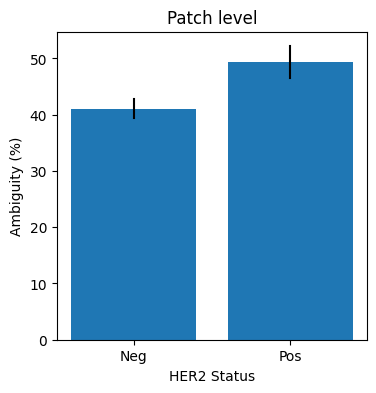

In [5]:
# What is the relation Ambi and label for each alpha
# graph: relation between Ambi and HER2 Status

def average_set_size(df):
    sizes = []
    for j in range(2):
        fdf = df \
            .filter(
                pl.col("label") == j
            )
        size = fdf.select("pred_size").mean().item()
        sizes.append(size)
    return sizes

rows = []
for r in range(r_min, r_max + 1):
    for f in range(cv):
        for alpha in alphas:
            file_path = root / f"{r}_{f}" / f"{r}_{f}_{alpha}_result.csv"

            df = pl.read_csv(file_path)
            set_sizes = average_set_size(df)

            row = [r, alpha] + set_sizes
            rows.append(row)

schema = ["r", "alpha"] + [f"set_size{i}" for i in range(2)]

result_df = pl.DataFrame(
        rows, schema=schema,
        orient="row"
    )

agg_result = result_df \
    .group_by("r", "alpha") \
    .agg(
        [
            pl.col(f"set_size{i}").mean()
            for i in range(2)
        ]
    ) \
    .sort("r", "alpha")

########################################################################################################

fig, ax = plt.subplots(figsize=(4, 4))

selected_alpha = 0.05

arr_sizes = agg_result \
    .filter(pl.col("alpha") == selected_alpha) \
    .select([f"set_size{i}" for i in range(2)]) \
    .to_numpy()

ambi_rate = arr_sizes.mean(axis=0) - 1


heights = []
for i in range(2):
    bi = bootstrap((arr_sizes - 1)[:,i].reshape(1,-1), statistic=np.mean)
    ci = bi.confidence_interval
    min_ci = ci.low * 100
    high_ci = ci.high * 100
    mean_ci = bi.bootstrap_distribution.mean() * 100

    heights.append(mean_ci)
    ax.plot([i, i], [min_ci, high_ci], c="k")
ax.set_xticks(
    ticks=np.arange(2), 
    labels=["Neg", "Pos"])
ax.set_xlabel("HER2 Status")
ax.set_ylabel("Ambiguity (%)")
ax.bar(np.arange(2), heights)
ax.set_title("Patch level")

(90.0, 95.0)

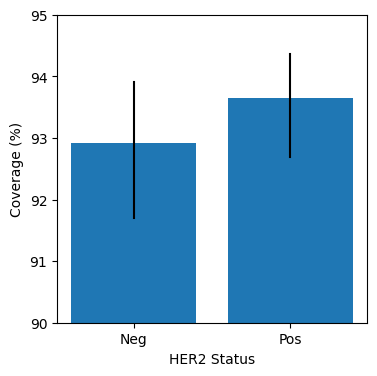

In [6]:
# Coverage vs. HER2 Status
rows = []
for r in range(r_min, r_max + 1):
    for f in range(cv):
        for alpha in alphas:
            file_path = root / f"{r}_{f}" / f"{r}_{f}_{alpha}_result.csv"

            df = pl.read_csv(file_path)
            cover = (
                        df 
                        .with_columns(
                            pl.when(
                                (pl.col("final_pred") == pl.col("label")) |
                                (pl.col("final_pred") == -1)
                            ).then(pl.lit(1))
                            .otherwise(0)
                            .alias("is_cover")
                        ) 
                        .group_by("label") 
                        .agg(
                            pl.col("is_cover").mean()
                        ) 
                        .sort("label").select("is_cover")
                        .to_numpy().reshape(-1).tolist()
                    )

            row = [r, alpha] + cover
            rows.append(row)

schema = ["r", "alpha"] + ["cover0", "cover1"]

result_df = pl.DataFrame(
        rows, schema=schema,
        orient="row"
    )

agg_result = result_df \
    .group_by("r", "alpha") \
    .agg(
        [
            pl.col(f"cover{i}").mean()
            for i in range(2)
        ]
    ) \
    .sort("r", "alpha")

########################################################################################################

fig, ax = plt.subplots(figsize=(4, 4))

selected_alpha = 0.05

arr_covers = agg_result \
    .filter(pl.col("alpha") == selected_alpha) \
    .select([f"cover{i}" for i in range(2)]) \
    .to_numpy()

avg_covers = arr_covers.mean(axis=0)

heights = []
for i in range(2):
    bi = bootstrap((arr_covers)[:,i].reshape(1,-1), statistic=np.mean)
    ci = bi.confidence_interval
    min_ci = ci.low * 100
    high_ci = ci.high * 100
    mean_ci = bi.bootstrap_distribution.mean() * 100

    heights.append(mean_ci)
    ax.plot([i, i], [min_ci, high_ci], c="k")
ax.set_xticks(
    ticks=np.arange(2), 
    labels=["Neg", "Pos"])
ax.set_xlabel("HER2 Status")
ax.set_ylabel("Coverage (%)")
ax.bar(np.arange(2), heights)
ax.set_ylim([90, 95])

(85.0, 101.0)

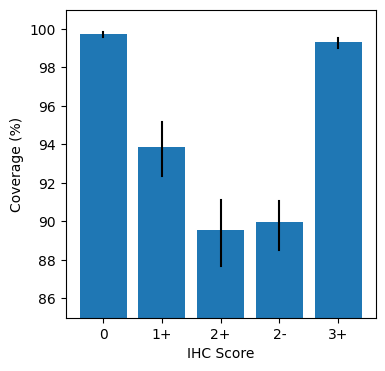

In [7]:
# Coverage vs. IHC status

rows = []
for r in range(r_min, r_max + 1):
    for f in range(cv):
        for alpha in alphas:
            file_path = root / f"{r}_{f}" / f"{r}_{f}_{alpha}_result.csv"

            df = pl.read_csv(file_path)
            cover = (
                df 
                .with_columns(
                    pl.when(
                        (pl.col("final_pred") == pl.col("label")) |
                        (pl.col("final_pred") == -1)
                    ).then(pl.lit(1))
                    .otherwise(0)
                    .alias("is_cover")
                ) 
                .group_by("ihc_score") 
                .agg(
                    pl.col("is_cover").mean()
                ) 
                .sort("ihc_score")
                .select("is_cover")
                .to_numpy().reshape(-1).tolist()
            )

            row = [r, alpha] + cover
            rows.append(row)

schema = ["r", "alpha"] + [f"cover{i}" for i in range(5)]

result_df = pl.DataFrame(
        rows, schema=schema,
        orient="row"
    )

agg_result = result_df \
    .group_by("r", "alpha") \
    .agg(
        [
            pl.col(f"cover{i}").mean()
            for i in range(5)
        ]
    ) \
    .sort("r", "alpha")

########################################################################################################

fig, ax = plt.subplots(figsize=(4, 4))

selected_alpha = 0.05

arr_covers = agg_result \
    .filter(pl.col("alpha") == selected_alpha) \
    .select([f"cover{i}" for i in range(5)]) \
    .to_numpy()

avg_covers = arr_covers.mean(axis=0)

heights = []
for i in range(5):
    bi = bootstrap((arr_covers)[:,i].reshape(1,-1), statistic=np.mean)
    ci = bi.confidence_interval
    min_ci = ci.low * 100
    high_ci = ci.high * 100
    mean_ci = bi.bootstrap_distribution.mean() * 100

    heights.append(mean_ci)
    ax.plot([i, i], [min_ci, high_ci], c="k")
ax.set_xticks(
    ticks=np.arange(5), 
    labels=["0", "1+", "2+", "2-", "3+"])
ax.set_xlabel("IHC Score")
ax.set_ylabel("Coverage (%)")
ax.bar(np.arange(5), heights)
ax.set_ylim([85, 101])

Text(0.5, 1.0, 'Patch level')

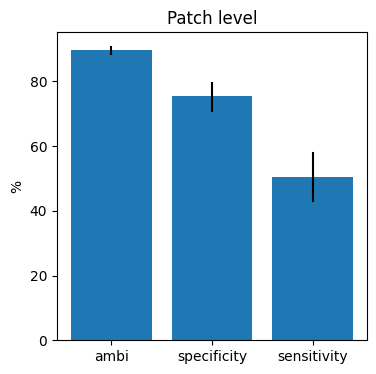

In [19]:
# Inspect only 2+ cases: 
#   - a) how many % that we predict as ambi / neg / pos?
#   - b) how was the relation between alpha?

rows = []
for r in range(r_min, r_max + 1):
    for f in range(cv):
        for alpha in alphas:
            file_path = root / f"{r}_{f}" / f"{r}_{f}_{alpha}_result.csv"
            df = pl.read_csv(file_path)

            agg = df.filter(pl.col("ihc_score").is_in([2, 3])) \
                .group_by("ihc_score", "final_pred") \
                .agg(
                    pl.len().alias("count")
                ) \
                .sort("ihc_score", "final_pred")

            tn = len(df.filter((pl.col("ihc_score") == 2) & (pl.col("final_pred") == 0)))
            tp = len(df.filter((pl.col("ihc_score") == 3) & (pl.col("final_pred") == 1)))
            fp = len(df.filter((pl.col("ihc_score") == 2) & (pl.col("final_pred") == 1)))
            fn = len(df.filter((pl.col("ihc_score") == 3) & (pl.col("final_pred") == 0)))
            ambi = len(df.filter((pl.col("final_pred") == -1) | pl.col("ihc_score").is_in([2, 3])))

            tot = tp + tn + fp + fn
            ambi_rate = ambi / (tot + ambi + 1e-8) # 2+ only
            specificity = tn / (tn + fp + 1e-8) # tnr
            sensitivity = tp / (tp + fn + 1e-8) # tpr

            stats = [ambi_rate, specificity, sensitivity]

            row = [r, alpha] + stats
            rows.append(row)

data_cols = ["ambi", "specificity", "sensitivity"]
schema = ["r", "alpha"] + data_cols

result_df = pl.DataFrame(
        rows, schema=schema,
        orient="row"
    )

agg_result = result_df \
    .group_by("r", "alpha") \
    .agg(
        [
            pl.col(col).mean()
            for col in data_cols
        ]
    ) \
    .sort("r", "alpha")

########################################################################################################

fig, ax = plt.subplots(figsize=(4, 4))

selected_alpha = 0.01

arr_stats = agg_result \
    .filter(pl.col("alpha") == selected_alpha) \
    .select(data_cols) \
    .to_numpy()

avg_stats = arr_stats.mean(axis=0)

heights = []
for i in range(len(data_cols)):
    bi = bootstrap((arr_stats)[:,i].reshape(1,-1), statistic=np.mean)
    ci = bi.confidence_interval
    min_ci = ci.low * 100
    high_ci = ci.high * 100
    mean_ci = bi.bootstrap_distribution.mean() * 100

    heights.append(mean_ci)
    ax.plot([i, i], [min_ci, high_ci], c="k")
ax.set_xticks(
    ticks=np.arange(len(data_cols)), 
    labels=data_cols)
ax.set_ylabel("%")
ax.bar(np.arange(len(data_cols)), heights)
ax.set_title("Patch level")
# ax.set_ylim([85, 101])

Text(0.5, 1.0, 'Ambiguity predictions of 2+ cases')

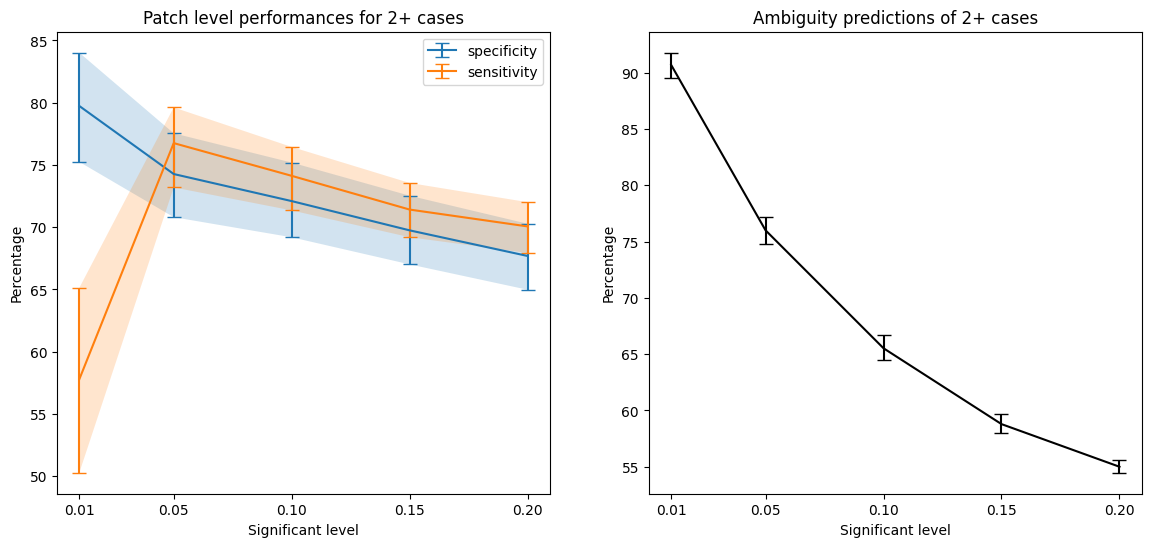

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

heights = {
    "ambi": {
        "mean": [],
        "err_min": [],
        "err_max": []
    },
    "specificity": {
        "mean": [],
        "err_min": [],
        "err_max": []
    },
    "sensitivity": {
        "mean": [],
        "err_min": [],
        "err_max": []
    }
}

for alpha in alphas:
    arr_stats = agg_result \
        .filter(pl.col("alpha") == alpha) \
        .select(data_cols) \
        .to_numpy()

    avg_stats = arr_stats.mean(axis=0)

    for i, col in enumerate(data_cols):
        bi = bootstrap((arr_stats)[:,i].reshape(1,-1), statistic=np.mean)
        ci = bi.confidence_interval
        min_ci = ci.low * 100
        high_ci = ci.high * 100
        mean_ci = bi.bootstrap_distribution.mean() * 100

        heights[col]["mean"].append(high_ci)
        heights[col]["err_min"].append(mean_ci - min_ci)
        heights[col]["err_max"].append(high_ci - mean_ci)
    #     ax.plot([i, i], [min_ci, high_ci], c="k")
    # ax.set_xticks(
    #     ticks=np.arange(len(data_cols)), 
    #     labels=data_cols)
    # ax.set_ylabel("%")
    # ax.bar(np.arange(len(data_cols)), heights)
    # ax.set_title("Patch level")
    # ax.set_ylim([85, 101])

lower_error = heights["specificity"]["err_min"]
upper_error = heights["specificity"]["err_max"]
asymmetric_error = [lower_error, upper_error]
axs[0].errorbar(
    alphas, 
    heights["specificity"]["mean"], 
    yerr=asymmetric_error, fmt='-', 
    label="specificity", capsize=5
)
x = alphas
y1 = np.array(heights["specificity"]["mean"]) - np.array(heights["specificity"]["err_min"])
y2 = np.array(heights["specificity"]["mean"]) + np.array(heights["specificity"]["err_max"])
axs[0].fill_between(x, y1, y2, alpha=.2)

lower_error = heights["sensitivity"]["err_min"]
upper_error = heights["sensitivity"]["err_max"]
asymmetric_error = [lower_error, upper_error]
axs[0].errorbar(
    alphas, 
    heights["sensitivity"]["mean"], 
    yerr=asymmetric_error, fmt='-', 
    label="sensitivity", capsize=5,
)
x = alphas
y1 = np.array(heights["sensitivity"]["mean"]) - np.array(heights["sensitivity"]["err_min"])
y2 = np.array(heights["sensitivity"]["mean"]) + np.array(heights["sensitivity"]["err_max"])
axs[0].fill_between(x, y1, y2, alpha=.2)

axs[0].set_xlabel("Significant level")
axs[0].set_ylabel("Percentage")
axs[0].legend()
axs[0].set_xticks(
    ticks=[0.01, 0.05, 0.1, 0.15, 0.2], 
    labels=["0.01", "0.05", "0.10", "0.15", "0.20"]
)
axs[0].set_title("Patch level performances for 2+ cases")


lower_error = heights["ambi"]["err_min"]
upper_error = heights["ambi"]["err_max"]
asymmetric_error = [lower_error, upper_error]
axs[1].errorbar(
    alphas, 
    heights["ambi"]["mean"], 
    yerr=asymmetric_error, fmt='-', 
    label="ambi", capsize=5,
    c="k"
)
# x = alphas
# y1 = np.array(heights["ambi"]["mean"]) - np.array(heights["ambi"]["err_min"])
# y2 = np.array(heights["ambi"]["mean"]) + np.array(heights["ambi"]["err_max"])
# axs[1].fill_between(x, y1, y2, alpha=.2, color="k")

axs[1].set_xlabel("Significant level")
axs[1].set_ylabel("Percentage")
axs[1].set_xticks(
    ticks=[0.01, 0.05, 0.1, 0.15, 0.2], 
    labels=["0.01", "0.05", "0.10", "0.15", "0.20"]
)
axs[1].set_title("Ambiguity predictions of 2+ cases")